# Import libraries


In [67]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.gridspec import GridSpec
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, MinMaxScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import recall_score, accuracy_score, f1_score, precision_score, make_scorer, ConfusionMatrixDisplay
from sklearn import decomposition, tree
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline


# Read data


In [68]:
df = pd.read_csv("healthcare-dataset-stroke-data.csv")
df.head()


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


# 1. Data exploration


In [69]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


In [70]:
df.describe()


,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,36517.829354,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,21161.721625,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,67.000000,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,36932.000000,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,54682.000000,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,72940.000000,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


## 1.1 Check for missing values


In [71]:
df.isna().sum()


id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

## 1.2 Handle missing values: assign missing values to the mean value according to each label


In [72]:
mean_bmi = df.groupby("stroke")["bmi"].agg(pd.Series.mean)
mean_bmi


stroke
0    28.823064
1    30.471292
Name: bmi, dtype: float64

In [73]:
df.loc[(df.stroke == 0) & (df.bmi.isna()), "bmi"] = mean_bmi[0]
df.loc[(df.stroke == 1) & (df.bmi.isna()), "bmi"] = mean_bmi[1]


In [74]:
df.isna().sum()


id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

# 2. Data visualization


## 2.1 Plot the probability density function (PDF) of continuous numerical features (avg_glucose_level, age, bmi) according to stroke


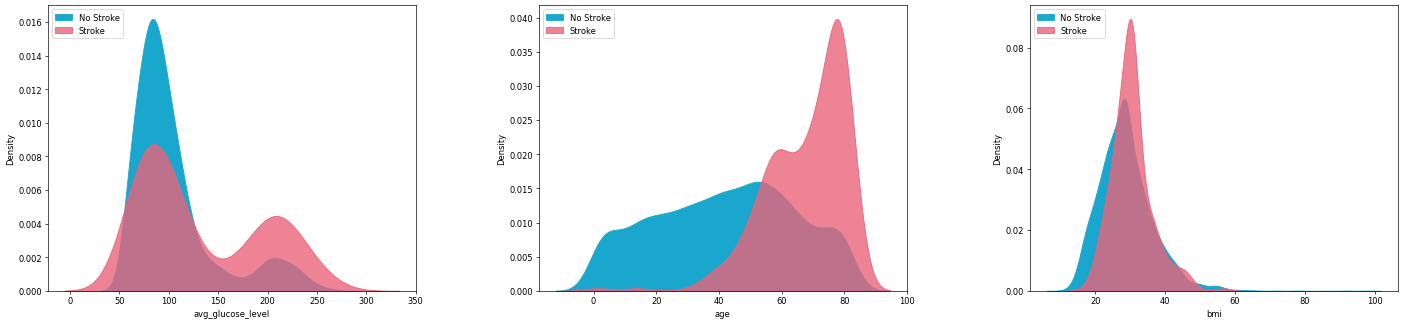

In [75]:
fig = plt.figure(figsize=(50, 15), dpi=60)
gs = GridSpec(ncols=28, nrows=12, left=0.05, right=0.5, wspace=1, hspace=0.1)

ax1 = fig.add_subplot(gs[1:6, 0:8])
ax2 = fig.add_subplot(gs[1:6, 10:18])
ax3 = fig.add_subplot(gs[1:6, 20:])

# Define colors
stroke_color = "#E96479"
not_stroke_color = "#19A7CE"

# Average Glucose Level
sns.kdeplot(
    x="avg_glucose_level",
    data=df[df.stroke == 0],
    ax=ax1,
    shade=True,
    color=not_stroke_color,
    alpha=1,
    label="No Stroke",
)
sns.kdeplot(
    x="avg_glucose_level",
    data=df[df.stroke == 1],
    ax=ax1,
    shade=True,
    color=stroke_color,
    alpha=0.8,
    label="Stroke",
)
ax1.legend(loc="upper left")

# Age
sns.kdeplot(
    x="age",
    data=df[df.stroke == 0],
    ax=ax2,
    shade=True,
    color=not_stroke_color,
    alpha=1,
    label="No Stroke",
)
sns.kdeplot(
    x="age",
    data=df[df.stroke == 1],
    ax=ax2,
    shade=True,
    color=stroke_color,
    alpha=0.8,
    label="Stroke",
)
ax2.legend(loc="upper left")

# BMI
sns.kdeplot(
    x="bmi",
    data=df[df.stroke == 0],
    ax=ax3,
    shade=True,
    color=not_stroke_color,
    alpha=1,
    label="No Stroke",
)
sns.kdeplot(
    x="bmi",
    data=df[df.stroke == 1],
    ax=ax3,
    shade=True,
    color=stroke_color,
    alpha=0.8,
    label="Stroke",
)
ax3.legend(loc="upper left")


# 3. Data preprocessing


## 3.1 Explore the categorical features


In [76]:
# explore categorical features (also known as nominal feature, are variables that contain label values rather than numeric values and often limited to a fixed set)

for col in ["gender", "work_type", "Residence_type", "smoking_status"]:
    print(f"{col}: {df[col].value_counts().to_dict()}")
    print("")


gender: {'Female': 2994, 'Male': 2115, 'Other': 1}

work_type: {'Private': 2925, 'Self-employed': 819, 'children': 687, 'Govt_job': 657, 'Never_worked': 22}

Residence_type: {'Urban': 2596, 'Rural': 2514}

smoking_status: {'never smoked': 1892, 'Unknown': 1544, 'formerly smoked': 885, 'smokes': 789}



## 3.2 Data Binning


In [77]:
df["bmi_bin"] = pd.qcut(df["bmi"], q=4)
df["avg_glucose_level_bin"] = pd.cut(df["avg_glucose_level"], bins=[
    0, 100, 125, 150, 200, 300])
# , labels=['Low', 'Normal', 'High', 'Very High']


In [78]:
df["bmi_bin"].value_counts(sort=True)


(10.299000000000001, 23.8]    1294
(23.8, 28.4]                  1282
(28.4, 32.8]                  1271
(32.8, 97.6]                  1263
Name: bmi_bin, dtype: int64

In [79]:
df["avg_glucose_level_bin"].value_counts(sort=True)


(0, 100]      3131
(100, 125]     979
(200, 300]     434
(150, 200]     296
(125, 150]     270
Name: avg_glucose_level_bin, dtype: int64

In [80]:
df["avg_glucose_level_bin"] = pd.cut(
    df["avg_glucose_level"],
    bins=[0, 100, 125, 150, 200, 300],
    labels=["Low", "Normal", "High", "Very High", "Extremely High"],
)


In [81]:
df["bmi_bin"] = pd.qcut(
    df["bmi"],
    q=4,
    labels=["Underweight", "Normal", "Overweight", "Obese"],
)


In [82]:
df


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_bin,avg_glucose_level_bin
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1,Obese,Extremely High
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,30.471292,never smoked,1,Overweight,Extremely High
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1,Overweight,Normal
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1,Obese,Very High
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1,Normal,Very High
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5105,18234,Female,80.0,1,0,Yes,Private,Urban,83.75,28.823064,never smoked,0,Overweight,Low
5106,44873,Female,81.0,0,0,Yes,Self-employed,Urban,125.20,40.000000,never smoked,0,Obese,High
5107,19723,Female,35.0,0,0,Yes,Self-employed,Rural,82.99,30.600000,never smoked,0,Overweight,Low
5108,37544,Male,51.0,0,0,Yes,Private,Rural,166.29,25.600000,formerly smoked,0,Normal,Very High


## 3.2 Extract the row with gender value = 'Other' (to put aside it for training set)


In [83]:
temp = df[df.gender == "Other"]
temp


,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,bmi_bin,avg_glucose_level_bin
3116,56156,Other,26.0,0,0,No,Private,Rural,143.33,22.4,formerly smoked,0,Underweight,High


In [84]:
df = df[df.gender != "Other"]


In [85]:
X = df.drop(["id", "avg_glucose_level", "bmi", "stroke"], axis=1)
y = df["stroke"]


In [86]:
temp_X = temp.drop(["id", "avg_glucose_level", "bmi", "stroke"], axis=1)
temp_y = temp["stroke"]


In [87]:
X.shape


(5109, 10)

## 3.3 Split the data into training set and test set (with stratification)


In [88]:
# split data into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=True, stratify=y, random_state=42)


In [89]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((3831, 10), (1278, 10), (3831,), (1278,))

## 3.4 Create an instance of column transformer to encode the categorical features

### One-hot encoding: for categorical data

### Ordinal encoding: for ordinal data


In [90]:
# create column transformer
ct = make_column_transformer(
    (OneHotEncoder(), ["gender"]),
    (OneHotEncoder(), ["ever_married"]),
    (OneHotEncoder(), ["work_type"]),
    (OneHotEncoder(), ["Residence_type"]),
    (
        OrdinalEncoder(
            categories=[["never smoked", "Unknown", "formerly smoked", "smokes"]]),
        ["smoking_status"],
    ),
    (
        OrdinalEncoder(
            categories=[["Low", "Normal", "High", "Very High", "Extremely High"]]),
        ["avg_glucose_level_bin"],
    ),
    (
        OrdinalEncoder(
            categories=[["Underweight", "Normal", "Overweight", "Obese"]]),
        ["bmi_bin"],
    ),
    remainder="passthrough",
)


## 3.5 Put the row with gender value = 'Other' back to the training set


In [91]:
X_train = pd.concat([X_train, temp_X], axis=0)


In [92]:
y_train = pd.concat([y_train, temp_y], axis=0)


In [93]:
X_train.shape, y_train.shape


((3832, 10), (3832,))

## 3.5 Fit transform the column transformer to the training set and transform the test set


In [94]:
X_train = ct.fit_transform(X_train)
X_test = ct.transform(X_test)


In [95]:
X_train.shape, y_train.shape


((3832, 18), (3832,))

In [96]:
transformed_cols = ct.get_feature_names_out()
transformed_cols


array(['onehotencoder-1__gender_Female', 'onehotencoder-1__gender_Male',
       'onehotencoder-1__gender_Other',
       'onehotencoder-2__ever_married_No',
       'onehotencoder-2__ever_married_Yes',
       'onehotencoder-3__work_type_Govt_job',
       'onehotencoder-3__work_type_Never_worked',
       'onehotencoder-3__work_type_Private',
       'onehotencoder-3__work_type_Self-employed',
       'onehotencoder-3__work_type_children',
       'onehotencoder-4__Residence_type_Rural',
       'onehotencoder-4__Residence_type_Urban',
       'ordinalencoder-1__smoking_status',
       'ordinalencoder-2__avg_glucose_level_bin',
       'ordinalencoder-3__bmi_bin', 'remainder__age',
       'remainder__hypertension', 'remainder__heart_disease'],
      dtype=object)

## 3.6 Data scaling


In [97]:
X_train


array([[ 1.,  0.,  0., ..., 72.,  1.,  1.],
       [ 0.,  1.,  0., ..., 18.,  0.,  0.],
       [ 1.,  0.,  0., ..., 13.,  0.,  0.],
       ...,
       [ 0.,  1.,  0., ..., 31.,  0.,  0.],
       [ 1.,  0.,  0., ..., 46.,  0.,  0.],
       [ 0.,  0.,  1., ..., 26.,  0.,  0.]])

In [98]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [99]:
X_train


array([[1.        , 0.        , 0.        , ..., 0.87781036, 1.        ,
        1.        ],
       [0.        , 1.        , 0.        , ..., 0.21798631, 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.1568915 , 0.        ,
        0.        ],
       ...,
       [0.        , 1.        , 0.        , ..., 0.37683284, 0.        ,
        0.        ],
       [1.        , 0.        , 0.        , ..., 0.5601173 , 0.        ,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.31573803, 0.        ,
        0.        ]])

# 4. Model training


## 4.1 Train model with no optimization


### 4.1.1 Train SVM model


In [100]:
svc_model = SVC()
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_svc)}")
print(f"Recall: {recall_score(y_test, y_pred_svc)}")
print(f"Precision: {precision_score(y_test, y_pred_svc)}")
print(f"F1-score: {f1_score(y_test, y_pred_svc)}")


Accuracy: 0.9514866979655712
Recall: 0.0
Precision: 0.0
F1-score: 0.0


In [101]:
def plotConFusionMatrix(y_test, y_pred):
    cmd = ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap="Blues")


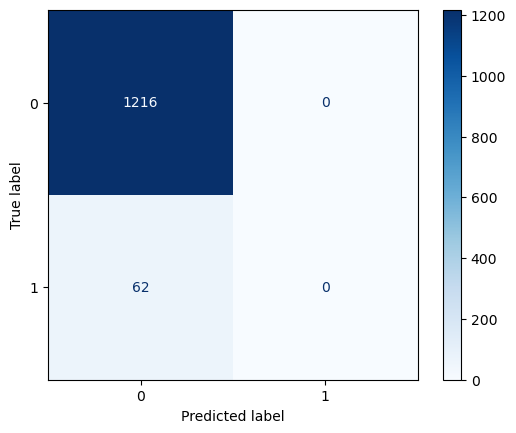

In [102]:
plotConFusionMatrix(y_test, y_pred_svc)


<div style="text-align: center;"> 
  <img src="https://static.packt-cdn.com/products/9781838555078/graphics/C13314_06_05.jpg" alt="Confusion Matrix">
</div>

<h4>TP: the number of patients who have stroke and the model predicts correctly that they have stroke </h4>
<h4>TN: the number of patients who do not have stroke and the model predicts correctly that they do not have stroke</h4>
<h4>FP: the number of patients who do not have stroke but the model predicts incorrectly that they have stroke</h4>
<h4>FN: the number of patients who have stroke but the model predicts incorrectly that they do not have stroke</h4>
<hr>
<h4> The goal is to optimize the recall score, where recall is defined as:</h4>

$$Recall = \frac{TP}{TP + FN}$$

#### It also means that we will minimize the number of FN (False Negative) because it is more dangerous to predict that a patient does not have stroke while he/she actually has stroke.


### 4.1.2 Train decision tree model


In [103]:
dt_model = DecisionTreeClassifier()
dt_model = dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred_dt)}')
print(f'Recall: {recall_score(y_test, y_pred_dt)}')
print(f'Precision: {precision_score(y_test, y_pred_dt)}')
print(f'F1-score: {f1_score(y_test, y_pred_dt)}')


Accuracy: 0.9162754303599374
Recall: 0.14516129032258066
Precision: 0.14285714285714285
F1-score: 0.144


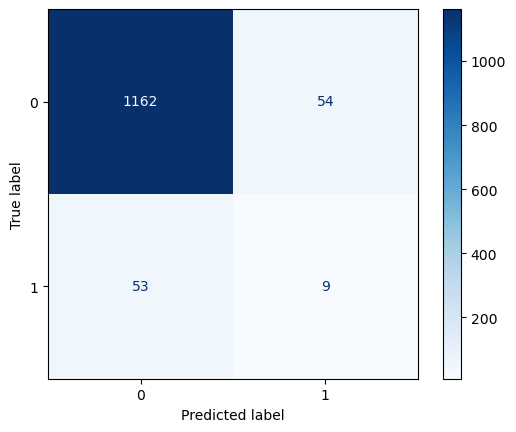

In [104]:
plotConFusionMatrix(y_test, y_pred_dt)


## 4.2 Train model with oversampling (SMOTE)


<Axes: xlabel='stroke', ylabel='count'>

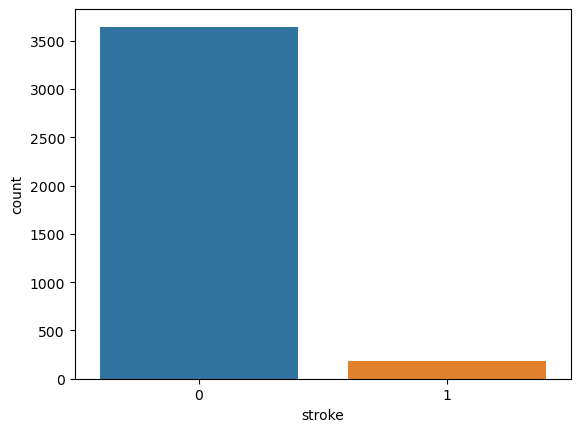

In [105]:
sns.countplot(x=y_train)


### It can be seen that the data is not balanced, therefore the model will be biased towards the majority class. Although the accuracy is high, the model is not good because the recall score is low (0%) (many stroke patients are predicted as non-stroke patients), which is very dangerous in the medical field.

### To solve this problem, we will use SMOTE (Synthetic Minority Over-sampling Technique) to balance the data.


In [106]:
oversample = SMOTE(k_neighbors=4, random_state=42)
X_train, y_train = oversample.fit_resample(X_train, y_train)


<Axes: xlabel='stroke', ylabel='count'>

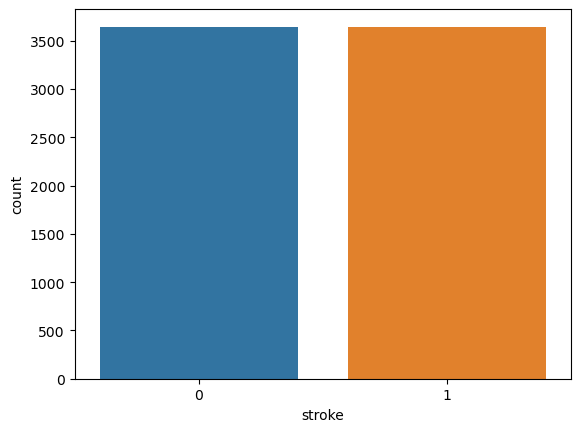

In [107]:
sns.countplot(x=y_train)


### 4.2.1 Train SVM model with SMOTE


In [108]:
svc_model = SVC()
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_svc)}")
print(f"Recall: {recall_score(y_test, y_pred_svc)}")
print(f"Precision: {precision_score(y_test, y_pred_svc)}")
print(f"F1-score: {f1_score(y_test, y_pred_svc)}")


Accuracy: 0.7785602503912363
Recall: 0.5806451612903226
Precision: 0.12286689419795221
F1-score: 0.2028169014084507


### 4.2.2 Train Decision Tree model with SMOTE


In [109]:
dt_model = DecisionTreeClassifier()
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt)}")
print(f"Recall: {recall_score(y_test, y_pred_dt)}")
print(f"Precision: {precision_score(y_test, y_pred_dt)}")
print(f"F1-score: {f1_score(y_test, y_pred_dt)}")


Accuracy: 0.8967136150234741
Recall: 0.12903225806451613
Precision: 0.09302325581395349
F1-score: 0.1081081081081081


## 4.3 Train model with feature selection (to reduce the number of dimensions)


In [110]:
# change numpy array to dataframe
X_train = pd.DataFrame(X_train)


<Axes: >

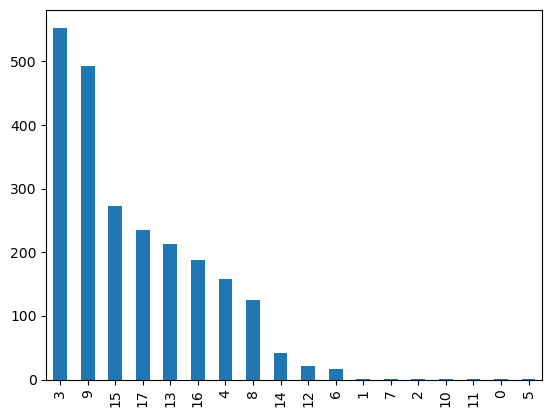

In [111]:
# The higher the chi-square value, the more important the feature is
chi_score = chi2(X_train, y_train)
chi_values = pd.Series(chi_score[0], index=X_train.columns)
chi_values.sort_values(ascending=False, inplace=True)
chi_values.plot.bar()


In [112]:
# important features
transformed_cols[3], transformed_cols[9], transformed_cols[15], transformed_cols[17], transformed_cols[
    13], transformed_cols[16], transformed_cols[4], transformed_cols[8], transformed_cols[14]


('onehotencoder-2__ever_married_No',
 'onehotencoder-3__work_type_children',
 'remainder__age',
 'remainder__heart_disease',
 'ordinalencoder-2__avg_glucose_level_bin',
 'remainder__hypertension',
 'onehotencoder-2__ever_married_Yes',
 'onehotencoder-3__work_type_Self-employed',
 'ordinalencoder-3__bmi_bin')

<Axes: >

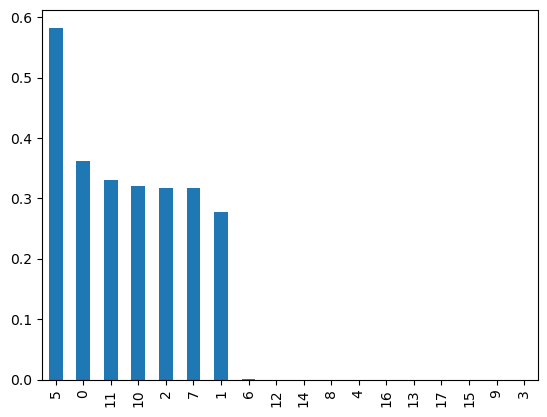

In [113]:
# The higher the p-value, the less important the feature is
p_values = pd.Series(chi_score[1], index=X_train.columns)
p_values.sort_values(ascending=False, inplace=True)
p_values.plot.bar()


In [114]:
# not important features
transformed_cols[5], transformed_cols[0], transformed_cols[11], transformed_cols[
    10], transformed_cols[2], transformed_cols[7], transformed_cols[1]


('onehotencoder-3__work_type_Govt_job',
 'onehotencoder-1__gender_Female',
 'onehotencoder-4__Residence_type_Urban',
 'onehotencoder-4__Residence_type_Rural',
 'onehotencoder-1__gender_Other',
 'onehotencoder-3__work_type_Private',
 'onehotencoder-1__gender_Male')

In [115]:
# select the 8 most important features
k_best = SelectKBest(chi2, k=8)
X_train = k_best.fit_transform(X_train, y_train)
X_test = k_best.transform(X_test)


### 4.3.1 Training SVM model with feature selection, but no hyperparameter tuning


In [116]:
svc_model = SVC()
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_svc)}")
print(f"Recall: {recall_score(y_test, y_pred_svc)}")
print(f"Precision: {precision_score(y_test, y_pred_svc)}")
print(f"F1-score: {f1_score(y_test, y_pred_svc)}")


Accuracy: 0.7206572769953051
Recall: 0.6935483870967742
Precision: 0.11286089238845144
F1-score: 0.19413092550790068


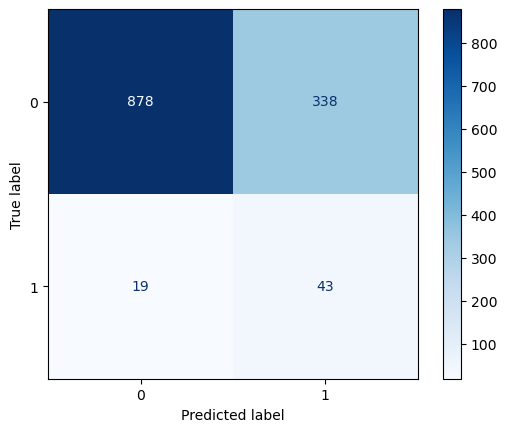

In [117]:
plotConFusionMatrix(y_test, y_pred_svc)


### 4.3.2 Training Decision Tree model with feature selection, but no hyperparameter tuning


In [118]:
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_dt)}")
print(f"Recall: {recall_score(y_test, y_pred_dt)}")
print(f"Precision: {precision_score(y_test, y_pred_dt)}")
print(f"F1-score: {f1_score(y_test, y_pred_dt)}")


Accuracy: 0.9280125195618153
Recall: 0.1935483870967742
Precision: 0.2222222222222222
F1-score: 0.20689655172413793


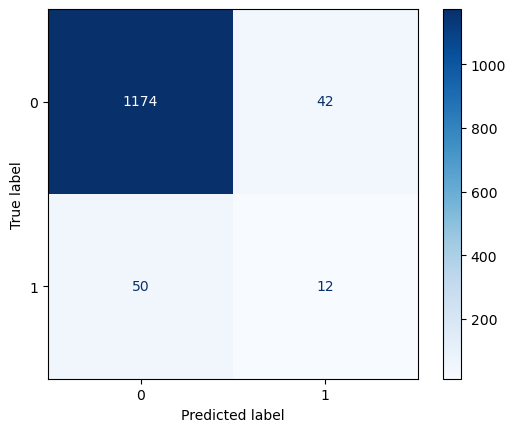

In [119]:
plotConFusionMatrix(y_test, y_pred_dt)


## 4.5 Train model with hyperparameter tuning using GridSearchCV


### 4.5.1 Train Decision tree model with oversampled data, feature selection, and hyperparameter tuning


In [120]:
# Creating a pca object
pca = decomposition.PCA()

# Creating a DecisionTreeClassifier
dec_tree = tree.DecisionTreeClassifier()

pipe = Pipeline(steps=[('pca', pca), ('dec_tree', dec_tree)])

# Creating lists of parameter for Decision Tree Classifier
criterion = ['gini', 'entropy']
max_depth = np.arange(2, 10)
min_samples_split_values = np.arange(2, 10)

# Creating a dictionary of all the parameter options
parameters = dict(dec_tree__criterion=criterion,
                  dec_tree__max_depth=max_depth,
                  dec_tree__min_samples_split=min_samples_split_values)

# Creating a grid search object with the scoring metric
clf_GS = GridSearchCV(pipe, parameters, scoring='recall', cv=5)

# Fitting the grid search
clf_GS.fit(X_train, y_train)

# Viewing The Best Parameters
print('Best max_depth:', clf_GS.best_estimator_.get_params()
      ['dec_tree__max_depth'])
print('Best criterion:', clf_GS.best_estimator_.get_params()
      ['dec_tree__criterion'])
print('Best min_samples_split:', clf_GS.best_estimator_.get_params()
      ['dec_tree__min_samples_split'])


Best max_depth: 3
Best criterion: gini
Best min_samples_split: 2


In [121]:
dt_model = DecisionTreeClassifier(
    criterion=clf_GS.best_estimator_.get_params()['dec_tree__criterion'],
    max_depth=clf_GS.best_estimator_.get_params(
    )['dec_tree__max_depth'], min_samples_split=clf_GS.best_estimator_.get_params()['dec_tree__min_samples_split'])
dt_model = dt_model.fit(X_train, y_train)
y_pred_dt = dt_model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, y_pred_dt)}')
print(f'Recall: {recall_score(y_test, y_pred_dt)}')
print(f'Precision: {precision_score(y_test, y_pred_dt)}')
print(f'F1-score: {f1_score(y_test, y_pred_dt)}')


Accuracy: 0.7550860719874805
Recall: 0.7741935483870968
Precision: 0.138328530259366
F1-score: 0.234718826405868


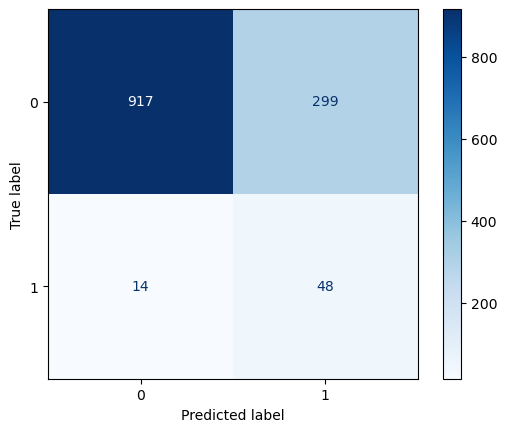

In [122]:
# confusion matrix
plotConFusionMatrix(y_test, y_pred_dt)


### Visualize the Decision Tree model


In [123]:
text_representation = tree.export_text(dt_model)
print(text_representation)


|--- feature_5 <= 0.63
|   |--- feature_5 <= 0.54
|   |   |--- feature_7 <= 0.00
|   |   |   |--- class: 0
|   |   |--- feature_7 >  0.00
|   |   |   |--- class: 0
|   |--- feature_5 >  0.54
|   |   |--- feature_6 <= 0.01
|   |   |   |--- class: 0
|   |   |--- feature_6 >  0.01
|   |   |   |--- class: 1
|--- feature_5 >  0.63
|   |--- feature_4 <= 0.00
|   |   |--- feature_5 <= 0.80
|   |   |   |--- class: 0
|   |   |--- feature_5 >  0.80
|   |   |   |--- class: 1
|   |--- feature_4 >  0.00
|   |   |--- feature_4 <= 0.25
|   |   |   |--- class: 1
|   |   |--- feature_4 >  0.25
|   |   |   |--- class: 1



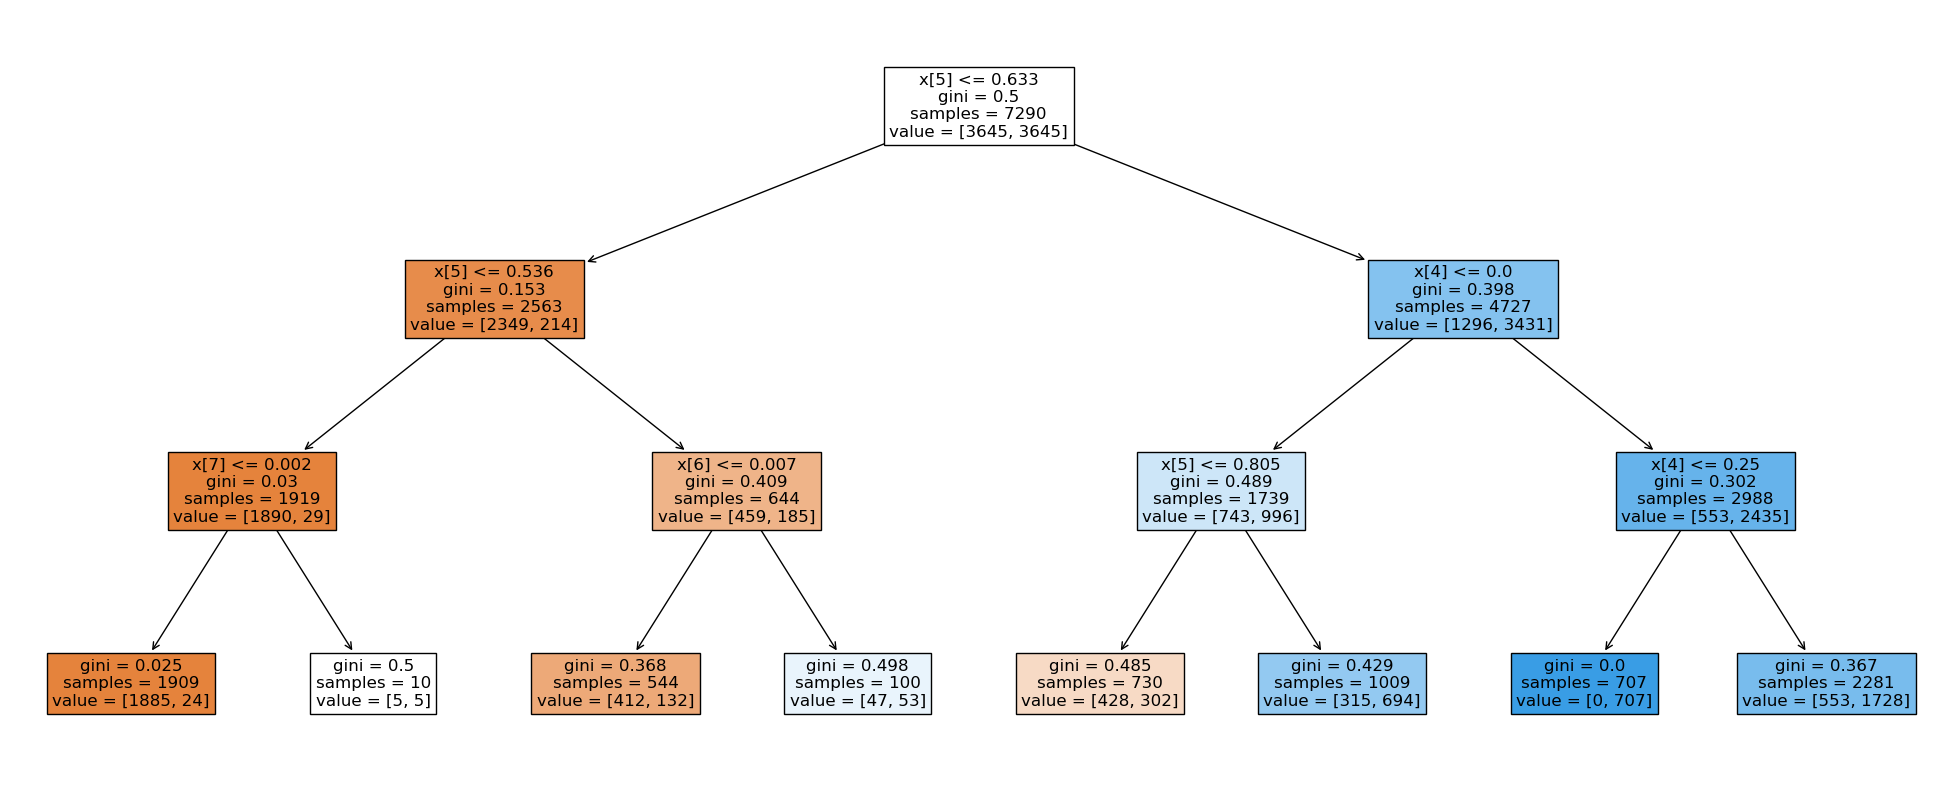

In [124]:
from sklearn.tree import plot_tree
plt.figure(figsize=(25, 10))
plot_tree(dt_model, filled=True, fontsize=12)
plt.show()

### 4.5.2 Training SVM model with optimal hyperparameters


In [125]:
# defining parameter range
param_grid = {'C': [0.1, 1, 10],
              'gamma': [1, 0.1, 0.01]
              }

# defining the scoring metric as recall
scoring = make_scorer(recall_score)

# creating the GridSearchCV object with the custom scoring metric
grid = GridSearchCV(SVC(), param_grid, refit=True,
                    verbose=3, scoring=scoring, cv=5)

# fitting the model for grid search
grid.fit(X_train, y_train)


Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV 1/5] END ....................C=0.1, gamma=1;, score=0.901 total time=   0.8s
[CV 2/5] END ....................C=0.1, gamma=1;, score=0.909 total time=   0.8s
[CV 3/5] END ....................C=0.1, gamma=1;, score=0.925 total time=   0.8s
[CV 4/5] END ....................C=0.1, gamma=1;, score=0.929 total time=   0.8s
[CV 5/5] END ....................C=0.1, gamma=1;, score=0.912 total time=   0.8s
[CV 1/5] END ..................C=0.1, gamma=0.1;, score=0.903 total time=   1.1s
[CV 2/5] END ..................C=0.1, gamma=0.1;, score=0.912 total time=   1.1s
[CV 3/5] END ..................C=0.1, gamma=0.1;, score=0.931 total time=   1.1s
[CV 4/5] END ..................C=0.1, gamma=0.1;, score=0.925 total time=   1.1s
[CV 5/5] END ..................C=0.1, gamma=0.1;, score=0.929 total time=   1.1s
[CV 1/5] END .................C=0.1, gamma=0.01;, score=0.948 total time=   1.5s
[CV 2/5] END .................C=0.1, gamma=0.01;,

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': [1, 0.1, 0.01]},
             scoring=make_scorer(recall_score), verbose=3)

In [126]:
# print best parameter after tuning
print(grid.best_params_)

# print how our model looks after hyper-parameter tuning
print(grid.best_estimator_)


{'C': 0.1, 'gamma': 0.01}
SVC(C=0.1, gamma=0.01)


In [127]:
svc_model = SVC(C=grid.best_params_['C'], gamma=grid.best_params_['gamma'])
svc_model.fit(X_train, y_train)
y_pred_svc = svc_model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred_svc)}")
print(f"Recall: {recall_score(y_test, y_pred_svc)}")
print(f"Precision: {precision_score(y_test, y_pred_svc)}")
print(f"F1-score: {f1_score(y_test, y_pred_svc)}")


Accuracy: 0.418622848200313
Recall: 0.9193548387096774
Precision: 0.07169811320754717
F1-score: 0.13302217036172695


# 5. Model evaluation


<!DOCTYPE html>
<html>
<head>
	<title></title> 
	<style>
		table {
			border:1px groove #000000;
			border-collapse:collapse;
			padding:5px;
		}
		table th {
			border:1px groove #000000;
			padding:5px;
			background: #d1d1d1;
			color: #000000;
		}
		table td {
			border:1px groove #000000;
			text-align:center;
			padding:5px;
			background: #ffffff;
			color: #313030;
		}
	</style>
</head>
<body>
    <table>
    	<thead>
    		<tr>
    			<th>Model</th>
    			<th>No optimization</th>
    			<th>Over-sampling</th>
    			<th>Feature selection</th>
    			<th>Hyper-parameter tuning</th>
    		</tr>
    	</thead>
    	<tbody>
    		<tr>
    			<td>&nbsp;SVM</td>
    			<td>&nbsp;0</td>
    			<td>&nbsp;0.58</td>
    			<td>&nbsp;0.69</td>
    			<td>0.92&nbsp;</td>
    		</tr>
    		<tr>
    			<td>&nbsp;Decision Tree</td>
    			<td>&nbsp;0.1</td>
    			<td>&nbsp;0.13</td>
    			<td>&nbsp;0.19</td>
    			<td>0.77</td>
    		</tr>
    	</tbody>
    </table>
</body>
</html>
